
## Object detction using YOLO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Object Detction

/content/drive/MyDrive/Colab Notebooks/Object Detction


100%|██████████| 106/106 [00:01<00:00, 94.22it/s]

car 99.51178431510925
person 98.53794574737549
car 96.82349562644958


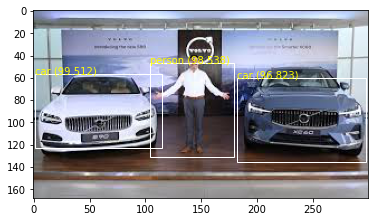

car 89.67030048370361
car 97.8148877620697
car 99.04746413230896


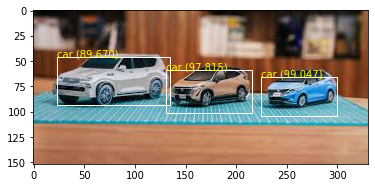

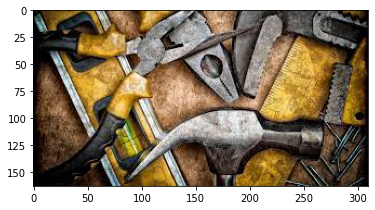

diningtable 77.57689952850342
chair 80.11130094528198


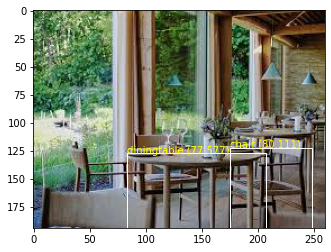

person 66.94080829620361
person 90.58106541633606
person 70.01423239707947
person 87.35049366950989
person 91.99925661087036
person 97.7414608001709
person 99.42548274993896


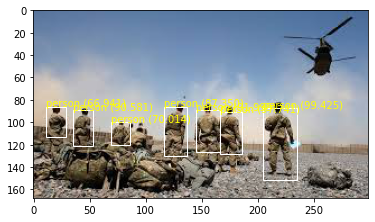

boat 83.03622603416443


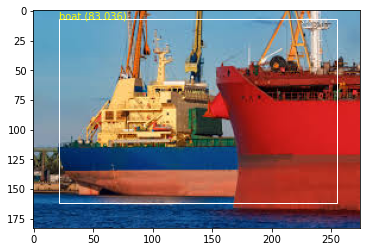

person 81.39369487762451


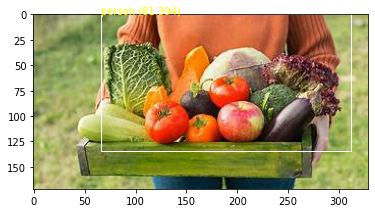

dog 97.24365472793579
dog 98.79151582717896


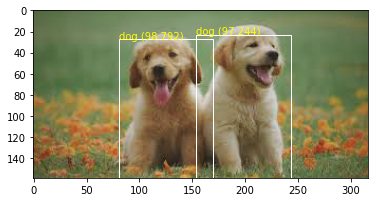

bird 90.6251609325409
dog 90.61436653137207
cat 82.7782928943634
dog 98.59520196914673


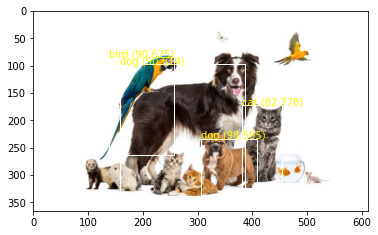

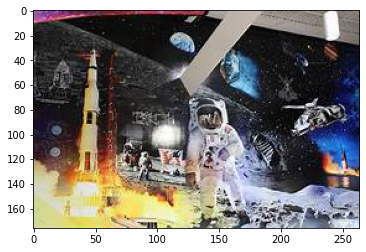

In [ ]:
import glob
import json
import struct

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major, = struct.unpack('i', w_f.read(4))
            minor, = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major * 10 + minor) >= 2 and \
                    major < 1000 and \
                    minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary,
                                         dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset - size:self.offset]

    def load_weights(self, model):
        for i in tqdm.tqdm(range(106)):
            try:
                conv_layer = model.get_layer(f'conv_{i}')

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer(f'bnorm_{i}')
                    size = np.prod(norm_layer.
                                   get_weights()[0].shape)
                    bias = self.read_bytes(size)
                    scale = self.read_bytes(size)
                    mean = self.read_bytes(size)
                    var = self.read_bytes(size)

                    norm_layer.set_weights([scale, bias,
                                            mean, var])

                if len(conv_layer.get_weights()) > 1:
                    bias = self.read_bytes(np.prod(
                        conv_layer.get_weights()[1].shape))

                    kernel = self.read_bytes(np.prod(
                        conv_layer.get_weights()[0].shape))

                    kernel = kernel.reshape(list(reversed(
                        conv_layer.get_weights()[0].shape)))

                    kernel = kernel.transpose([2, 3, 1, 0])

                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(
                        conv_layer.get_weights()[0].shape))

                    kernel = kernel.reshape(list(reversed(
                        conv_layer.get_weights()[0].shape)))

                    kernel = kernel.transpose([2, 3, 1, 0])

                    conv_layer.set_weights([kernel])
            except ValueError:
                pass

    def reset(self):
        self.offset = 0


class BoundBox(object):
    def __init__(self, x_min, y_min, x_max, y_max,
                 objness=None,
                 classes=None):
        self.xmin = x_min
        self.ymin = y_min
        self.xmax = x_max
        self.ymax = y_max
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score


class YOLO(object):
    def __init__(self, weights_path,
                 anchors_path='/content/drive/MyDrive/Colab Notebooks/Object Detction/content/resources/anchors.json',
                 labels_path='/content/drive/MyDrive/Colab Notebooks/Object Detction/content/resources/coco_labels.txt',
                 class_threshold=0.65):
        self.weights_path = weights_path
        self.model = self._load_yolo()

        self.labels = []
        with open(labels_path, 'r') as f:
            for l in f:
                self.labels.append(l.strip())

        with open(anchors_path, 'r') as f:
            self.anchors = json.load(f)

        self.class_threshold = class_threshold

    def _conv_block(self, input, convolutions, skip=True):
        x = input
        count = 0
        for conv in convolutions:
            if count == (len(convolutions) - 2) and skip:
                skip_connection = x

            count += 1

            if conv['stride'] > 1:
                x = ZeroPadding2D(((1, 0), (1, 0)))(x)

            x = Conv2D(conv['filter'],
                       conv['kernel'],
                       strides=conv['stride'],
                       padding=('valid' if conv['stride'] > 1
                                else 'same'),
                       name=f'conv_{conv["layer_idx"]}',
                       use_bias=(False if conv['bnorm']
                                 else True))(x)

            if conv['bnorm']:
                name = f'bnorm_{conv["layer_idx"]}'
                x = BatchNormalization(epsilon=1e-3,
                                       name=name)(x)
            if conv['leaky']:
                name = f'leaky_{conv["layer_idx"]}'
                x = LeakyReLU(alpha=0.1, name=name)(x)

        return Add()([skip_connection, x]) if skip else x

    def _make_yolov3_architecture(self):
        input_image = Input(shape=(None, None, 3))

        # Layer  0 => 4
        x = self._conv_block(input_image, [
            {'filter': 32, 'kernel': 3, 'stride': 1,
             'bnorm': True,
             'leaky': True, 'layer_idx': 0},
            {'filter': 64, 'kernel': 3, 'stride': 2,
             'bnorm': True,
             'leaky': True, 'layer_idx': 1},
            {'filter': 32, 'kernel': 1, 'stride': 1,
             'bnorm': True,
             'leaky': True, 'layer_idx': 2},
            {'filter': 64, 'kernel': 3, 'stride': 1,
             'bnorm': True,
             'leaky': True, 'layer_idx': 3}])

        # Layer  5 => 8
        x = self._conv_block(x, [
            {'filter': 128, 'kernel': 3, 'stride': 2,
             'bnorm': True, 'leaky': True, 'layer_idx': 5},
            {'filter': 64, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 6},
            {'filter': 128, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 7}])

        # Layer  9 => 11
        x = self._conv_block(x, [
            {'filter': 64, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 9},
            {'filter': 128, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 10}])

        # Layer 12 => 15
        x = self._conv_block(x, [
            {'filter': 256, 'kernel': 3, 'stride': 2,
             'bnorm': True, 'leaky': True, 'layer_idx': 12},
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 13},
            {'filter': 256, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 14}])

        # Layer 16 => 36
        for i in range(7):
            x = self._conv_block(x, [
                {'filter': 128, 'kernel': 1, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 16 + i * 3},
                {'filter': 256, 'kernel': 3, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 17 + i * 3}])
        skip_36 = x

        # Layer 37 => 40
        x = self._conv_block(x, [
            {'filter': 512, 'kernel': 3, 'stride': 2,
             'bnorm': True, 'leaky': True, 'layer_idx': 37},
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 38},
            {'filter': 512, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 39}])

        # Layer 41 => 61
        for i in range(7):
            x = self._conv_block(x, [
                {'filter': 256, 'kernel': 1, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 41 + i * 3},
                {'filter': 512, 'kernel': 3, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 42 + i * 3}])
        skip_61 = x

        # Layer 62 => 65
        x = self._conv_block(x, [
            {'filter': 1024, 'kernel': 3, 'stride': 2,
             'bnorm': True, 'leaky': True, 'layer_idx': 62},
            {'filter': 512, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 63},
            {'filter': 1024, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 64}])

        # Layer 66 => 74
        for i in range(3):
            x = self._conv_block(x, [
                {'filter': 512, 'kernel': 1, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 66 + i * 3},
                {'filter': 1024, 'kernel': 3, 'stride': 1,
                 'bnorm': True, 'leaky': True,
                 'layer_idx': 67 + i * 3}])

        # Layer 75 => 79
        x = self._conv_block(x, [
            {'filter': 512, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 75},
            {'filter': 1024, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 76},
            {'filter': 512, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 77},
            {'filter': 1024, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 78},
            {'filter': 512, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 79}],
                             skip=False)

        # Layer 80 => 82
        yolo_82 = self._conv_block(x, [
            {'filter': 1024, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 80},
            {'filter': 255, 'kernel': 1, 'stride': 1,
             'bnorm': False, 'leaky': False,
             'layer_idx': 81}], skip=False)

        # Layer 83 => 86
        x = self._conv_block(x, [
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 84}],
                             skip=False)
        x = UpSampling2D(2)(x)
        x = Concatenate()([x, skip_61])

        # Layer 87 => 91
        x = self._conv_block(x, [
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 87},
            {'filter': 512, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 88},
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 89},
            {'filter': 512, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 90},
            {'filter': 256, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 91}],
                             skip=False)
        # Layer 92 => 94
        yolo_94 = self._conv_block(x, [
            {'filter': 512, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 92},
            {'filter': 255, 'kernel': 1, 'stride': 1,
             'bnorm': False, 'leaky': False,
             'layer_idx': 93}], skip=False)

        # Layer 95 => 98
        x = self._conv_block(x, [
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 96}],
                             skip=False)
        x = UpSampling2D(2)(x)
        x = Concatenate()([x, skip_36])

        # Layer 99 => 106
        yolo_106 = self._conv_block(x, [
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 99},
            {'filter': 256, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 100},
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 101},
            {'filter': 256, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 102},
            {'filter': 128, 'kernel': 1, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 103},
            {'filter': 256, 'kernel': 3, 'stride': 1,
             'bnorm': True, 'leaky': True, 'layer_idx': 104},
            {'filter': 255, 'kernel': 1, 'stride': 1,
             'bnorm': False, 'leaky': False,
             'layer_idx': 105}], skip=False)

        return Model(inputs=input_image,
                     outputs=[yolo_82, yolo_94, yolo_106])

    def _load_yolo(self):
        model = self._make_yolov3_architecture()
        weight_reader = WeightReader(self.weights_path)
        weight_reader.load_weights(model)
        model.save('model.h5')

        model = load_model('model.h5',compile=False)

        return model

    @staticmethod
    def _sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    def _decode_net_output(self, network_output,
                           anchors,
                           obj_thresh,
                           network_height,
                           network_width):
        grid_height, grid_width = network_output.shape[:2]
        nb_box = 3
        network_output = network_output.reshape(
            (grid_height, grid_width, nb_box, -1))

        boxes = []
        network_output[..., :2] = \
            self._sigmoid(network_output[..., :2])
        network_output[..., 4:] = \
            self._sigmoid(network_output[..., 4:])
        network_output[..., 5:] = \
            (network_output[..., 4][..., np.newaxis] *
             network_output[..., 5:])
        network_output[..., 5:] *= \
            network_output[..., 5:] > obj_thresh

        for i in range(grid_height * grid_width):
            r = i / grid_width
            c = i % grid_width

            for b in range(nb_box):
                objectness = \
                    network_output[int(r)][int(c)][b][4]

                if objectness.all() <= obj_thresh:
                    continue

                x, y, w, h = \
                    network_output[int(r)][int(c)][b][:4]
                x = (c + x) / grid_width
                y = (r + y) / grid_height
                w = (anchors[2 * b] * np.exp(w) /
                     network_width)
                h = (anchors[2 * b + 1] * np.exp(h) /
                     network_height)

                classes = network_output[int(r)][c][b][5:]
                box = BoundBox(x_min=x - w / 2,
                               y_min=y - h / 2,
                               x_max=x + w / 2,
                               y_max=y + h / 2,
                               objness=objectness,
                               classes=classes)
                boxes.append(box)

        return boxes

    @staticmethod
    def _correct_yolo_boxes(boxes,
                            image_height,
                            image_width,
                            network_height,
                            network_width):
        new_w, new_h = network_width, network_height

        for i in range(len(boxes)):
            x_offset = (network_width - new_w) / 2.0
            x_offset /= network_width
            x_scale = float(new_w) / network_width

            y_offset = (network_height - new_h) / 2.0
            y_offset /= network_height
            y_scale = float(new_h) / network_height

            boxes[i].xmin = int((boxes[i].xmin - x_offset) /
                                x_scale * image_width)
            boxes[i].xmax = int((boxes[i].xmax - x_offset) /
                                x_scale * image_width)
            boxes[i].ymin = int((boxes[i].ymin - y_offset) /
                                y_scale * image_height)
            boxes[i].ymax = int((boxes[i].ymax - y_offset) /
                                y_scale * image_height)

    @staticmethod
    def _interval_overlap(interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b

        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2, x4) - x1
        else:
            if x2 < x3:
                return 0
            else:
                return min(x2, x4) - x3

    def _bbox_iou(self, box1, box2):
        intersect_w = self._interval_overlap(
            [box1.xmin, box1.xmax],
            [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap(
            [box1.ymin, box1.ymax],
            [box2.ymin, box2.ymax])

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
        w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

        union = w1 * h1 + w2 * h2 - intersect
        return float(intersect) / union

    def _non_max_suppression(self, boxes, nms_thresh):
        if len(boxes) > 0:
            nb_class = len(boxes[0].classes)
        else:
            return

        for c in range(nb_class):
            sorted_indices = np.argsort(
                [-box.classes[c] for box in boxes])

            for i in range(len(sorted_indices)):
                index_i = sorted_indices[i]

                if boxes[index_i].classes[c] == 0:
                    continue

                for j in range(i + 1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    iou = self._bbox_iou(boxes[index_i],
                                         boxes[index_j])
                    if iou >= nms_thresh:
                        boxes[index_j].classes[c] = 0

    def _get_boxes(self, boxes):
        v_boxes, v_labels, v_scores = [], [], []

        for box in boxes:
            for i in range(len(self.labels)):
                if box.classes[i] > self.class_threshold:
                    v_boxes.append(box)
                    v_labels.append(self.labels[i])
                    v_scores.append(box.classes[i] * 100)

        return v_boxes, v_labels, v_scores

    @staticmethod
    def _draw_boxes(filename, v_boxes, v_labels, v_scores):
        data = plt.imread(filename)
        plt.imshow(data)

        ax = plt.gca()

        for i in range(len(v_boxes)):
            box = v_boxes[i]

            y1, x1, y2, x2 = \
                box.ymin, box.xmin, box.ymax, box.xmax

            width = x2 - x1
            height = y2 - y1

            rectangle = Rectangle((x1, y1), width, height,
                                  fill=False, color='white')

            ax.add_patch(rectangle)
            label = f'{v_labels[i]} ({v_scores[i]:.3f})'
            plt.text(x1, y1, label, color='yellow')
        plt.show()

    def detect(self, image, width, height):
        image = np.expand_dims(image, axis=0)
        preds = self.model.predict(image)

        boxes = []

        for i in range(len(preds)):
            boxes.extend(
                self._decode_net_output(preds[i][0],
                                        self.anchors[i],
                                        self.class_threshold,
                                        416,
                                        416))

        self._correct_yolo_boxes(boxes, height, width, 416,
                                 416)
        self._non_max_suppression(boxes, .5)

        valid_boxes, valid_labels, valid_scores = \
            self._get_boxes(boxes)

        for i in range(len(valid_boxes)):
            print(valid_labels[i], valid_scores[i])

        self._draw_boxes(image_path,
                         valid_boxes,
                         valid_labels,
                         valid_scores)


model = YOLO(weights_path='/content/drive/MyDrive/Colab Notebooks/Object Detction/content/yolov3.weights')

for image_path in glob.glob('/content/drive/MyDrive/Colab Notebooks/Object Detction/images for detection/*.jpg'):
    image = load_img(image_path, target_size=(416, 416))
    image = img_to_array(image)
    image = image.astype('float32') / 255.0

    original_image = load_img(image_path)
    width, height = original_image.size

    model.detect(image, width, height)